# Problem Statement:
## Customer Personality Analysis
We will be perfoming EDA, Univariate and Bivariate Analysis to get insights about customers.
<br>
<br>
As well as using unsupervised learning techniques.
### Goal:
Perform clustering to summarize customer segments.
### Purpose / Business Implementation:
Help business better understand its customers and their habits, behavior and needs. 
<br>
<br>
Customer Segmentation helps business to modify products based on its target customers from different customer segments. 


### TABLE OF CONTENTS:
* [LOAD DATA](#LOAD-DATA)
* [DATA CLEANING](#DATA-CLEANING)
* [FEATURE ENGINEERING](#FEATURE-ENGINEERING)
* [UNIVARIATE ANALYSIS](#UNIVARIATE-ANALYSIS)
* [FEATURE CORRELATION](#FEATURE-CORRELATION)
* [BIVARIATE ANALYSIS](#BIVARIATE-ANALYSIS)
* [CLUSTERING](#CLUSTERING)
* [MODEL EVALUATION](#MODEL-EVALUATION)
* [CLUSTERING SUMMARY](#CLUSTERING-SUMMARY)

In [1]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(5)

### LOAD DATA <a class="anchor" id="LOAD-DATA"></a>

In [2]:
# Loading data
data = pd.read_csv("data\marketing_campaign.csv", sep="\t")

In [3]:
# Let's take a look at the data
color_map = sns.light_palette("green", as_cmap=True)
data.head(5).style.background_gradient(cmap=color_map)

##### Dataset features

<img src="images/attributes.png">

##### Quick look at data statistics

In [4]:
# Basic statistics
data.describe().style.background_gradient(cmap=color_map)

### DATA CLEANING

In [5]:
# Info about columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**Takeaways**
* Looks like we have some missing values in Income feature.
* Dt_Customer feature is not parsed as date.


Let's deal with missing values.

In [6]:
print("Percentage of missing values in Income column: ", round(data["Income"].isnull().sum() / len(data) * 100, 2), "%")

Percentage of missing values in Income column:  1.07 %


We are missing only 1% of values. Let's fill them with median values.

In [7]:
# Filling in missing values
data["Income"] = data["Income"].fillna(data["Income"].median())

In [8]:
# Check if we have any more missing values
data.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

Now as we have dealt with missing values, let's convert Dt_Customer feature to date object.

In [9]:
# Converting Dt_Customer feature from Object type to Datetime type
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)

In [10]:
data["Dt_Customer"].sample(3)

1364   2013-07-25
812    2014-05-31
2015   2013-03-29
Name: Dt_Customer, dtype: datetime64[ns]

Number of unique values in each column:

In [11]:
data.nunique()

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1975
Kidhome                   3
Teenhome                  3
Dt_Customer             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

Z_CostContact and Z_Revenue have 1 unique values each, so they won't contribute anything to analysis or model. We will drop them.

In [12]:
# Dropping columns
data.drop(["Z_CostContact", "Z_Revenue"], axis=1, inplace=True)

Let's examine some of features before we proceed to feature engineering.

In [13]:
# Education Feature
data["Education"].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [14]:
# Marital_Status Feauture
data["Marital_Status"].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

### FEATURE ENGINEERING

* Retrieve Age Feature from Year_Birth column
* Convert Education values to Undergraduate and Postgraduate
* Convert Marital_Status values to Single and Relationship
* Retrieve Children Feature from Kidhome and Teenhome to indicate total amount of children
* Retrieve Spent Feature from Product Features to indicate total amount spent on all products
* Retrieve Customer_For feature from Dt_Customer to indicate for how many years individual has been a customer
* Retrieve TotalPurchases from Place Attributes to indicate number of purchase made from all sources
* Retrieve TotalAcceptedCmp from Promotion Features to indicate total number of accepted offers throughout all campaigns
* Create Is_Parent Feature where 1 if Children > 0 and 0 if Children = 0

In [15]:
# First let's rename product features
data.rename(columns={"MntWines": "Wines", "MntFruits": "Fruits", "MntMeatProducts": "Meat", "MntFishProducts": "Fish", 
                     "MntSweetProducts": "Sweets", "MntGoldProds": "Gold"}, inplace=True)

In [16]:
# Age Feature 
data["Age"] = 2022 - data["Year_Birth"]

# Education Feature
data["Education"] = data["Education"].replace(['Graduation', 'PhD', 'Master', '2n Cycle'], "Post Graduate")
data["Education"] = data["Education"].replace(["Basic"], "Under Graduate")

# Marital_Status
data["Marital_Status"] = data["Marital_Status"].replace(['Together', 'Married'], "Relationship")
data["Marital_Status"] = data["Marital_Status"].replace(['Single', 'Divorced', 'Widow', 'Alone','Absurd', 'YOLO'], "Single")

# Children Feature
data["Children"] = data["Teenhome"] + data["Kidhome"]

# Spent Feature
data["Spent"] = data["Wines"] + data["Fruits"] + data["Meat"] + data["Fish"] + data["Sweets"] + data["Gold"]

# Customer_For Feature
years = []
for date in data["Dt_Customer"]:
    years.append(2022 - date.year)
data["Customer_For"] = years

# TotalPurchases Feature
data["TotalPurchases"] = data["NumWebPurchases"] + data["NumCatalogPurchases"] + data["NumStorePurchases"]

# TotalAcceptedCmp Feature
data["TotalAcceptedCmp"] = data["AcceptedCmp1"] + data["AcceptedCmp2"] + data["AcceptedCmp3"] + data["AcceptedCmp4"] + data["AcceptedCmp5"]

# Is_Parent Feature
data["Is_Parent"] = np.where(data.Children > 0, 1, 0)

# Dropping some columns 
drop_columns = ["ID", "Year_Birth", "Dt_Customer"]
data.drop(drop_columns, axis=1, inplace=True)

Let's look how our data looks now.

In [17]:
data.head(5).style.background_gradient(cmap=color_map)

### UNIVARIATE ANALYSIS
#### Education Feature

<AxesSubplot:xlabel='Education', ylabel='Count'>

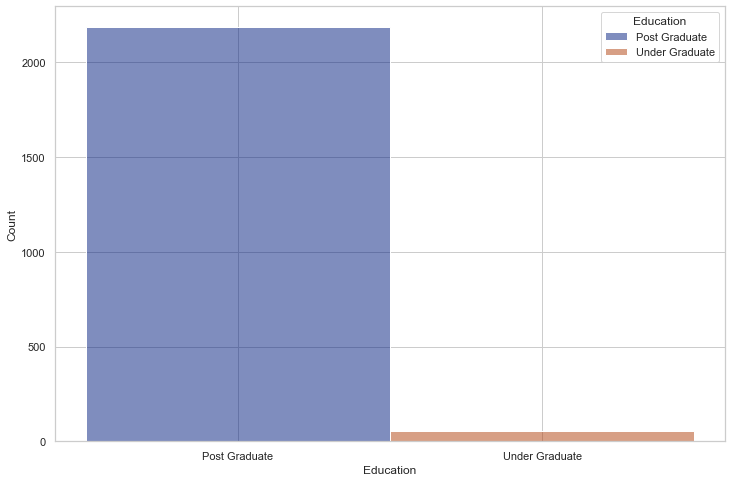

In [18]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(data=data, x="Education", hue="Education", palette="dark")

In [19]:
data.Education.value_counts()

Post Graduate     2186
Under Graduate      54
Name: Education, dtype: int64

#### Marital Status Feature

<AxesSubplot:xlabel='Marital_Status', ylabel='Count'>

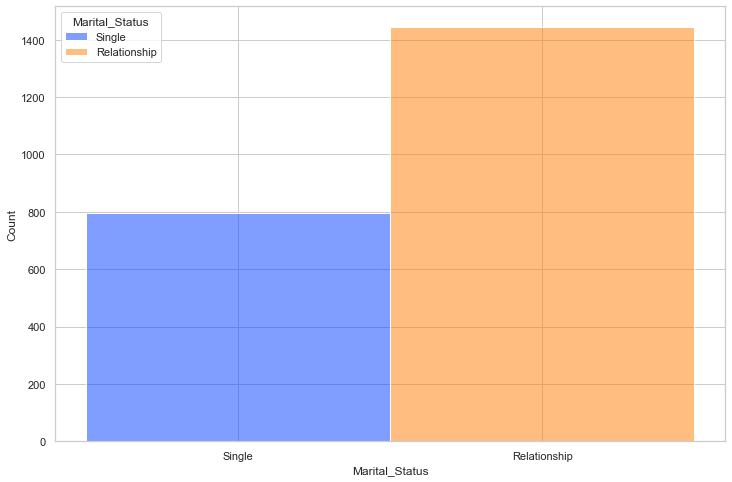

In [20]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(data=data, x="Marital_Status", hue="Marital_Status", palette="bright")

In [21]:
data.Marital_Status.value_counts()

Relationship    1444
Single           796
Name: Marital_Status, dtype: int64

#### Income Feature

<AxesSubplot:xlabel='Income', ylabel='Density'>

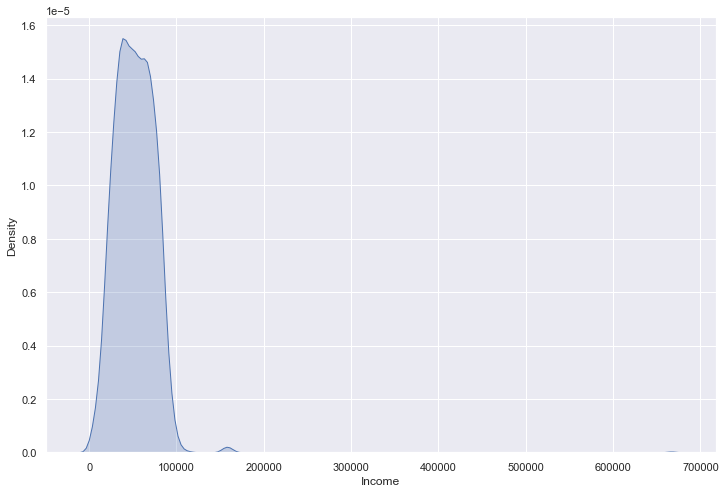

In [22]:
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
sns.kdeplot(data["Income"], shade=True)

Looks like we have some extreme outliers. We will drop them.

In [23]:
data = data[(data["Income"] < 600000)]

<AxesSubplot:ylabel='Income'>

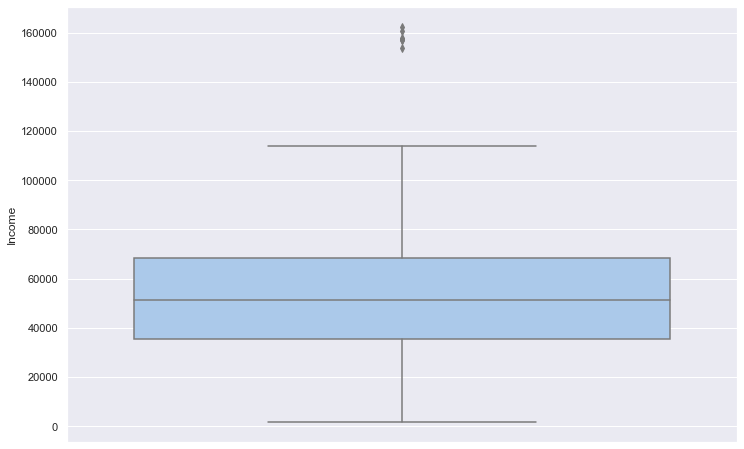

In [24]:
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid", palette="pastel")
sns.boxplot(data=data, y="Income")

<AxesSubplot:xlabel='Income', ylabel='Count'>

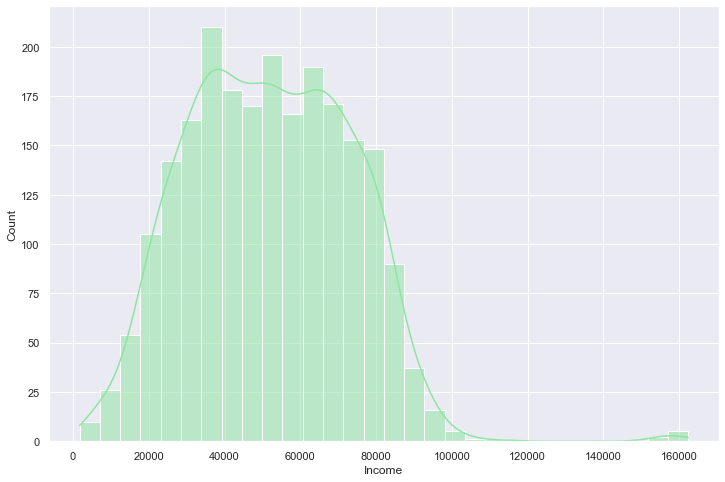

In [25]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="darkgrid", palette="pastel")
sns.histplot(x=data[(data.Income < 200000)].Income, bins=30, kde=True, color="g")

In [26]:
# Median Income
data["Income"].median()

51381.5

<AxesSubplot:>

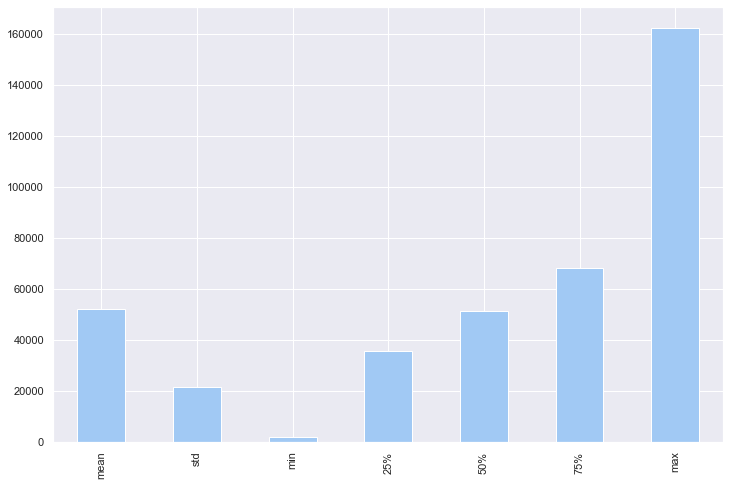

In [27]:
data["Income"].describe()[1:].plot(kind="bar", figsize=(12, 8))

#### Age Feature

<AxesSubplot:xlabel='Age', ylabel='Count'>

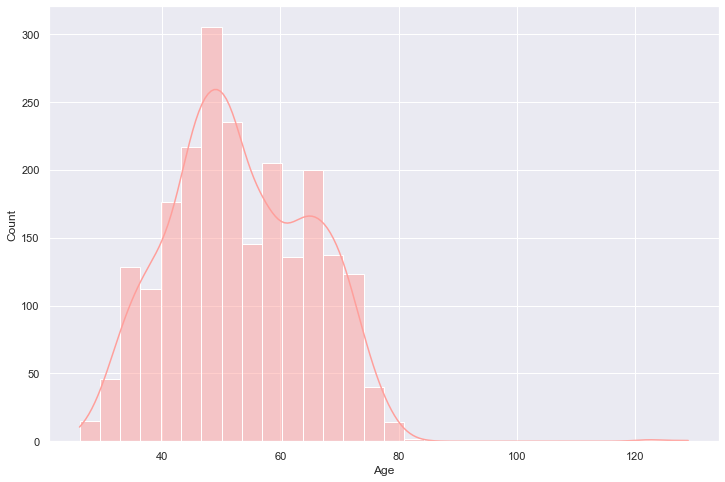

In [28]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="darkgrid", palette="pastel")
sns.histplot(data=data, x="Age", bins=30, kde=True, color="r")

In [29]:
# Average Age
data["Age"].mean()

53.19785618579723

We have some extreme outliers. We will drop them.

In [30]:
data = data[(data["Age"] < 90)]

#### Is_Parent Feature

<AxesSubplot:xlabel='Is_Parent', ylabel='Count'>

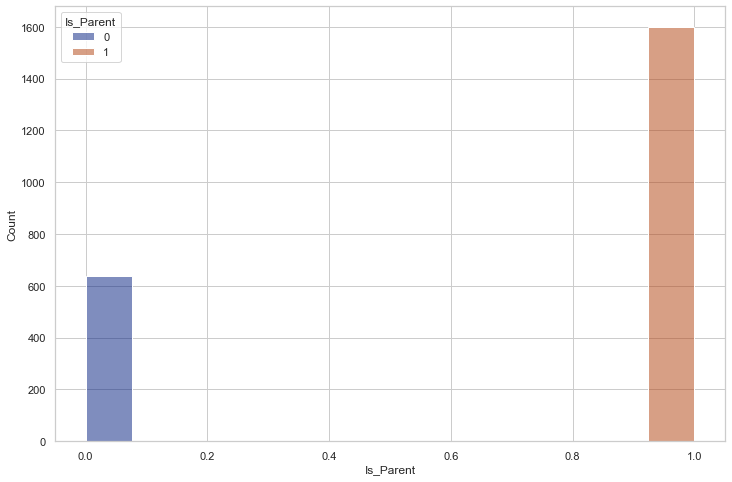

In [31]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(data=data, x="Is_Parent", hue="Is_Parent", palette="dark")

#### Children Feature

<AxesSubplot:xlabel='Children', ylabel='Count'>

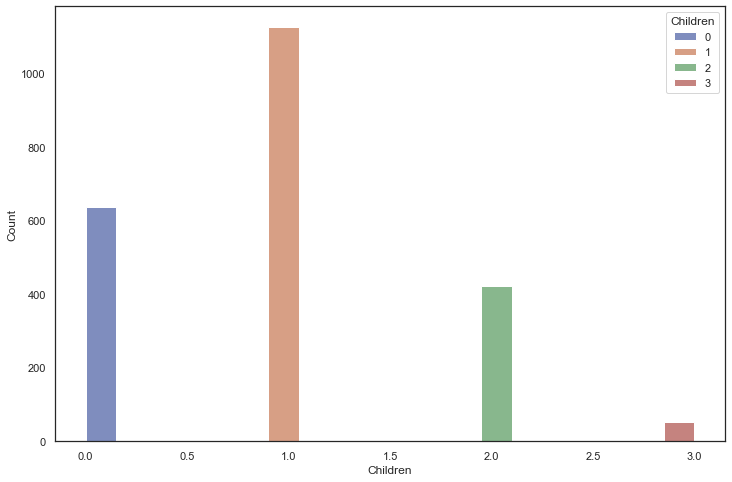

In [32]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="white", palette="pastel")
sns.histplot(data=data, x="Children", palette="dark", hue="Children")

In [33]:
data.Children.value_counts()

1    1125
0     637
2     421
3      53
Name: Children, dtype: int64

#### Spent Feature

<AxesSubplot:xlabel='Spent', ylabel='Count'>

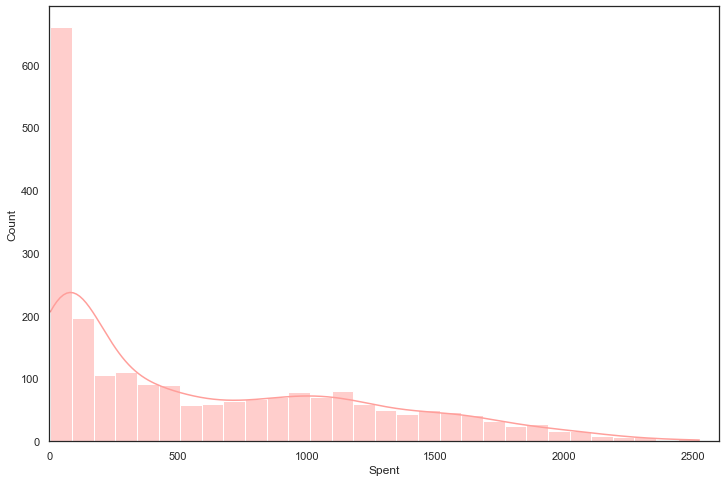

In [34]:
plt.figure(figsize=(12, 8))
plt.xlim(0, 2600)
sns.set_theme(style="darkgrid", palette="pastel")
sns.histplot(data=data, x="Spent", bins=30, kde=True, color="r")

<AxesSubplot:ylabel='Spent'>

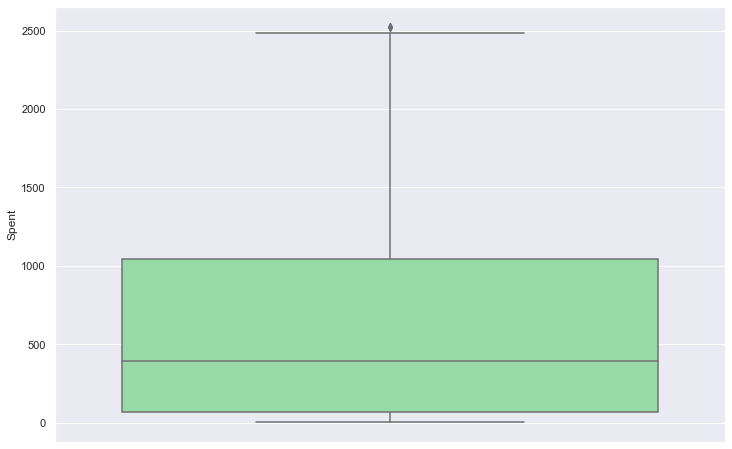

In [35]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="darkgrid", palette="pastel")
sns.boxplot(data=data, y="Spent", color="g")

<AxesSubplot:>

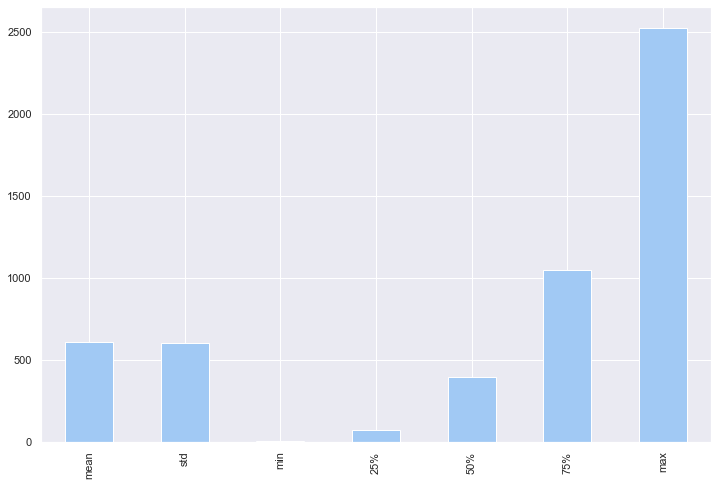

In [36]:
data["Spent"].describe()[1:].plot(kind="bar", figsize=(12, 8))

In [37]:
data["Spent"].describe()

count    2236.000000
mean      605.986583
std       601.865156
min         5.000000
25%        69.000000
50%       396.500000
75%      1045.500000
max      2525.000000
Name: Spent, dtype: float64

#### Customer_For Feature

In [38]:
data["Customer_For"].unique()

array([10,  8,  9], dtype=int64)

<AxesSubplot:xlabel='Customer_For', ylabel='Count'>

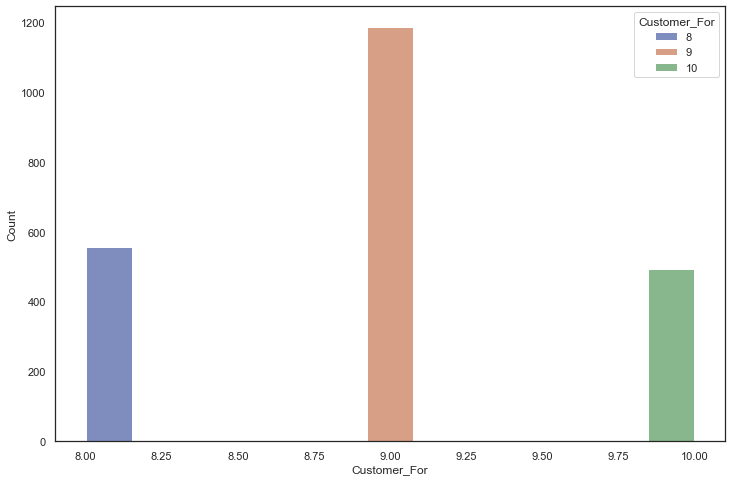

In [39]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="white", palette="pastel")
sns.histplot(data=data, x="Customer_For", palette="dark", hue="Customer_For")

In [40]:
data["Customer_For"].value_counts()

9     1186
8      556
10     494
Name: Customer_For, dtype: int64

#### Total Amount Of Puchases via Web / Cataloque / Stores

<AxesSubplot:xlabel='TotalPurchases', ylabel='Count'>

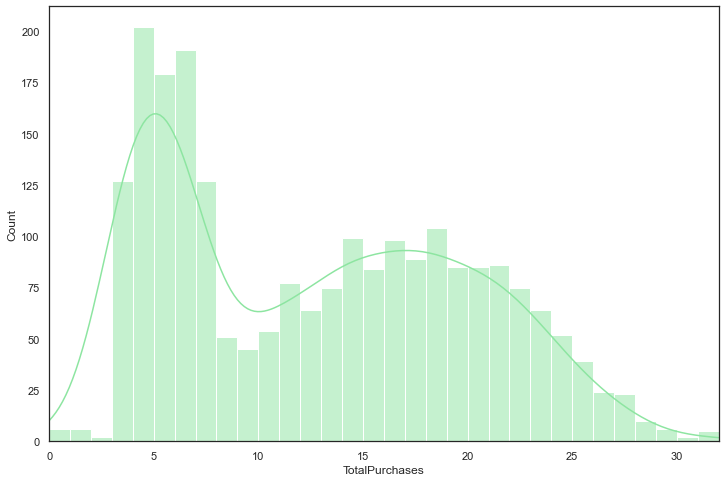

In [41]:
plt.figure(figsize=(12, 8))
plt.xlim(0, 32)
sns.set_theme(style="darkgrid", palette="pastel")
sns.histplot(data=data, x="TotalPurchases", bins=32, kde=True, color="g")

<AxesSubplot:>

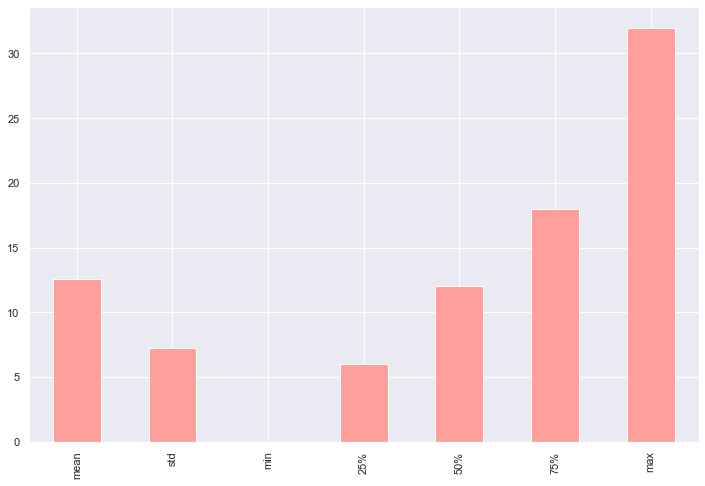

In [42]:
data["TotalPurchases"].describe()[1:].plot(kind="bar", figsize=(12, 8), color="r")

In [43]:
data["TotalPurchases"].describe()

count    2236.000000
mean       12.546512
std         7.206577
min         0.000000
25%         6.000000
50%        12.000000
75%        18.000000
max        32.000000
Name: TotalPurchases, dtype: float64

#### Total Accepted Offers in Campaigns Feature

<AxesSubplot:xlabel='TotalAcceptedCmp', ylabel='Count'>

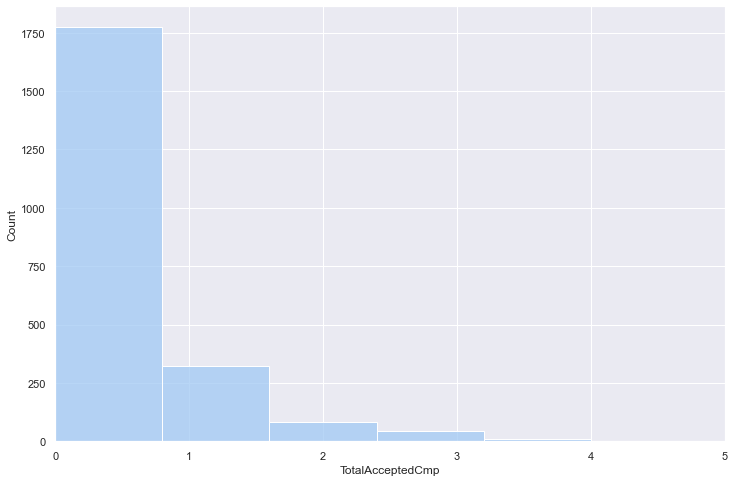

In [44]:
plt.figure(figsize=(12, 8))
plt.xlim(0, 5)
sns.set_theme(style="darkgrid", palette="pastel")
sns.histplot(data=data, x="TotalAcceptedCmp", bins=5, color="b")

In [45]:
data["TotalAcceptedCmp"].value_counts()

0    1774
1     324
2      83
3      44
4      11
Name: TotalAcceptedCmp, dtype: int64

### FEATURE CORRELATION

<AxesSubplot:>

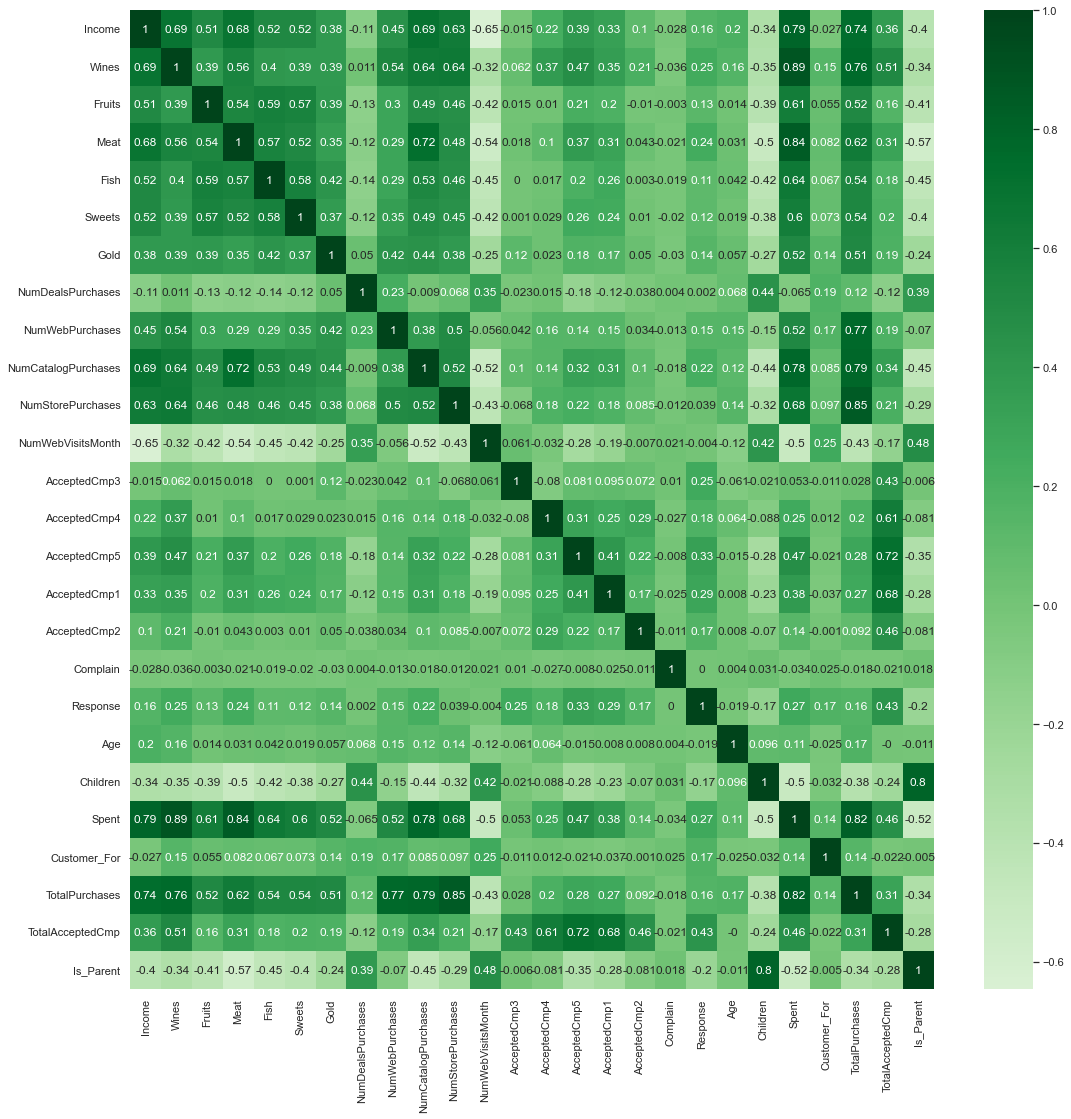

In [46]:
# Correlation Matrix without Categorical Values
correlation = round(data.drop(["Recency", "Kidhome", "Teenhome"], axis=1).corr(), 3)
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, annot=True, cmap="Greens", center=0)

### BIVARIATE ANALYSIS
Not all features will be included. I will be perfoming Pair plot on a subset with features I think most important.

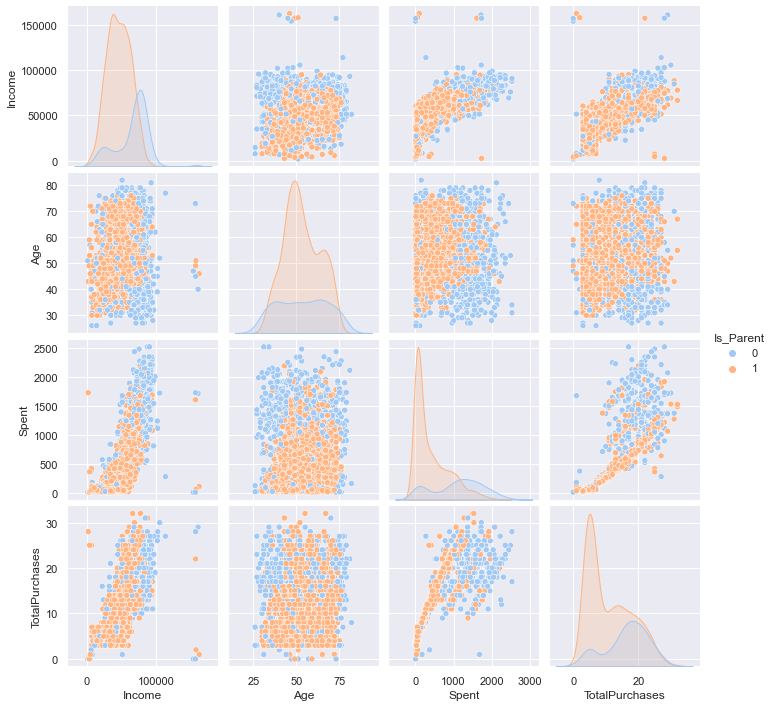

In [47]:
to_plot = ["Income" , "Age", "Spent", "TotalPurchases", "Is_Parent"]
sns.pairplot(data[to_plot], hue="Is_Parent")

### OBSERVATIONS

* Almost all Customers in the dataset are Post Graduates( 2186 vs 54 )
* 63% of Customers are in a Relationship and 36% are Single
* Median and Mean Income of Customers is around 53000 dollars
* Most of the customers are 40+ years and Mean Age is 53 years old
* 72% of Customers in the dataset are Parents
* 1125 Customers have 1 kid, 421 Cusomers have 2 kids, 53 Customers have 3 kids and 637 have no kids
* Median spent is around 400 dollars. Mean spent is around 600 dollars.
* 53 % of Customers are 9 year clients, 25% are 8 year clients and 22% are 10 year clients
* Median and Mean of Total Purchases is 12 and 12.5 respectively
* 80% of Customers didn't accept a single offer throughout campaigns
* Amount Spent seems to increase with Income
* Non-Parents seem to spend more compared to Parents

### CLUSTERING

#### Dealing with Categorical Variables

First of all, let's encode our categorical values.

In [48]:
data.select_dtypes(include=(object)).columns

Index(['Education', 'Marital_Status'], dtype='object')

We have two categorical variables - Education and Marital Status. Let's encode them using LabelEncoder.

In [49]:
# Import Label Encoder
from sklearn.preprocessing import LabelEncoder

In [50]:
le = LabelEncoder()
data["Education"] = le.fit_transform(data["Education"])
data["Marital_Status"] = le.fit_transform(data["Marital_Status"])

Post Graduate is now 0 and Under Graduate is 1. Relationship is 0, Single is 1.

#### Scaling the Data

In [51]:
from sklearn.preprocessing import StandardScaler

In [52]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [53]:
scaled_data.head(3).style.background_gradient(cmap=color_map)

#### Reducing Dimensionality of Data

We have a lot of features right now in our dataset and many of them are correlated with each other, which means we can perform dimensionality reduction to leave only principal features. Big number of features makes working with them harder and can cause overfitting and longer training, because algorithm takes time processing unnecessary features that do not add any value.

In [54]:
from sklearn.decomposition import PCA

We will be using PCA - Principal Component Analysis. It is one of the leading linear techniques of dimensionality reduction. This method performs a direct mapping of the data to a lesser dimensional space in a way that maximizes the variance of the data in the low-dimensional representation.

In [55]:
pca = PCA(n_components=3)
PCA_data = pd.DataFrame(pca.fit_transform(scaled_data), columns=(["col1","col2", "col3"]))
PCA_data

col1      col2      col3
0     4.615873  0.110445 -1.199032
1    -3.161003  0.144515  0.099392
2     2.301051 -0.375551 -1.695715
3    -2.936629 -1.452595 -0.166205
4    -0.661334  0.233679 -0.714801
...        ...       ...       ...
2231  2.225991  2.095054 -1.060718
2232 -1.347698  2.980836  2.766000
2233  2.598775 -1.208426  0.830627
2234  1.659311  1.697779 -1.159181
2235 -2.251248  1.208268  1.094000

[2236 rows x 3 columns]

We reduced dimensionality from 31 to 3. 

In [56]:
import plotly.express as px

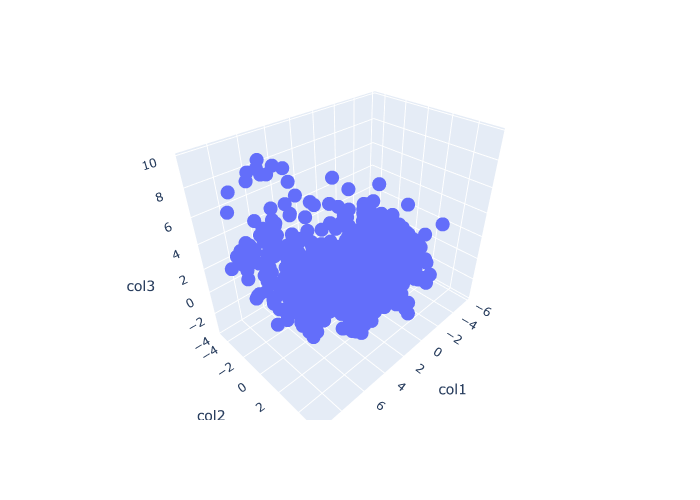

In [57]:
# Plotting reduced dataset
fig = px.scatter_3d(PCA_data, x="col1", y="col2", z="col3")
fig.show("png") # Remove "png" and rerun to make plot interactive

#### Fitting the Model

We will be using Elbow Method for figuring our number of clusters we need and Bisecting K-Means clustering to form our clusters.

In [58]:
# Imports for clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

Let's use Elbow Method to figure out how many clusters we need.

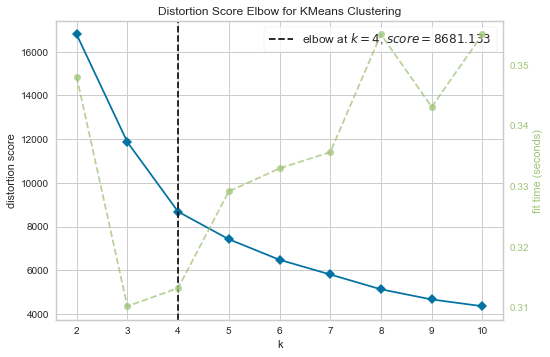

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [59]:
visualizer = KElbowVisualizer(KMeans(), k=10)
visualizer.fit(PCA_data)
visualizer.show()

4 clusters seems to be working well. Now let's fit Bisecting K-Means Model.

In [60]:
from sklearn.cluster import BisectingKMeans

In [61]:
# Fitting the Model
clusters = BisectingKMeans(n_clusters=4).fit_predict(PCA_data)

In [62]:
# Join data with clusters
PCA_data["Clusters"] = clusters
PCA_data["Clusters"] = PCA_data["Clusters"].replace([0, 1, 2, 3], [1, 2, 3, 4])

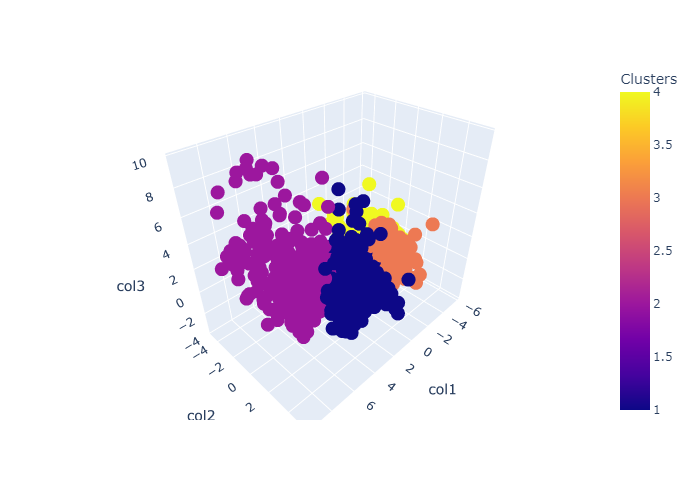

In [63]:
# Cluster plot
fig = px.scatter_3d(PCA_data, x="col1", y="col2", z="col3", color="Clusters")
fig.show("png") # Remove "png" and rerun to make plot interactive

### MODEL EVALUATION

In [64]:
data["Clusters"] = clusters
data["Clusters"] = data["Clusters"].replace([0, 1, 2, 3], [1, 2, 3, 4])

In [65]:
sns.set_theme(style="darkgrid")

<AxesSubplot:xlabel='Clusters', ylabel='Count'>

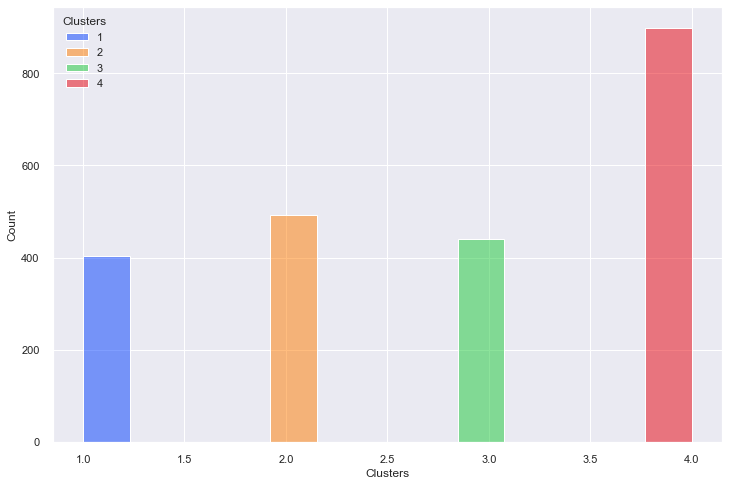

In [66]:
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x="Clusters", hue="Clusters", palette="bright")

Forth cluster seem to hold much more data points than the others which are pretty similar in size.

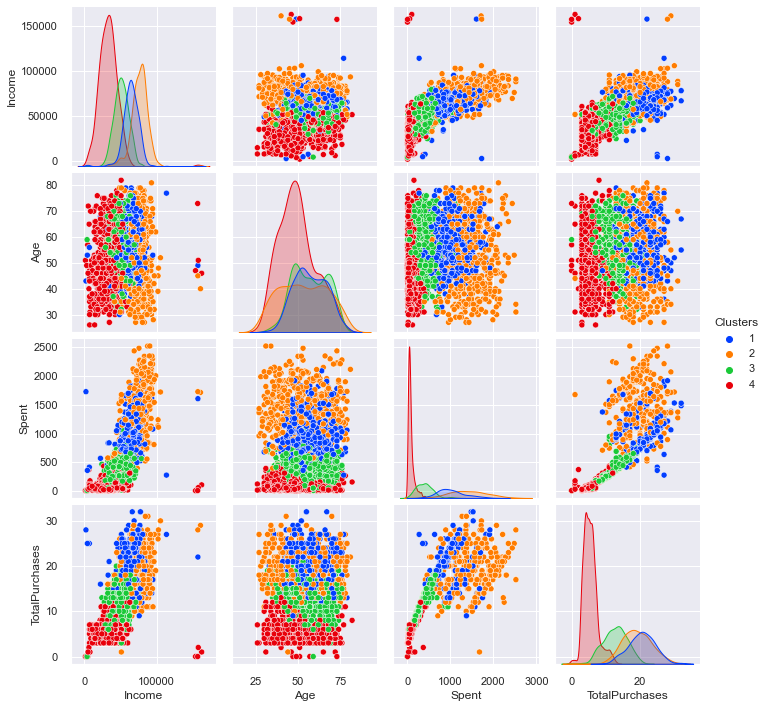

In [67]:
to_plot = ["Income" , "Age", "Spent", "TotalPurchases", "Clusters"]
sns.pairplot(data[to_plot], hue="Clusters", palette="bright")

<AxesSubplot:xlabel='Income', ylabel='Count'>

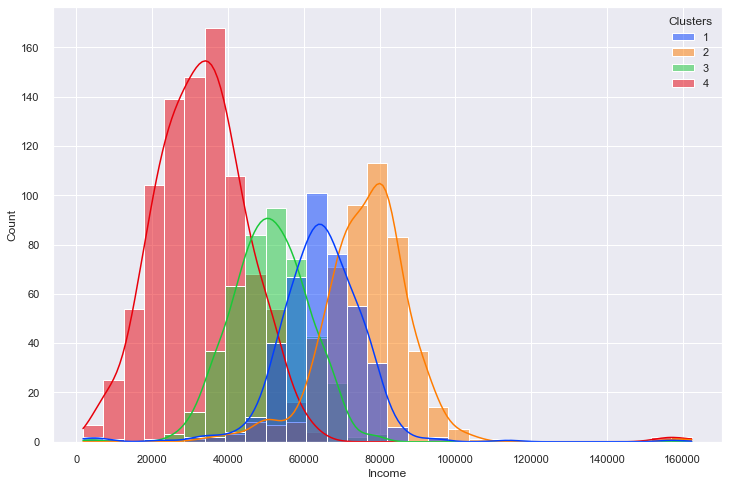

In [68]:
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x="Income", bins=30, kde=True, hue="Clusters", palette="bright")

* 4 Cluster seems to be Low Income
* 3 Cluster seems to be Low-Medium Income
* 2 Cluster seems to be High Income
* 1 Cluster seems to be Medium-High Income

<AxesSubplot:xlabel='TotalPurchases', ylabel='Count'>

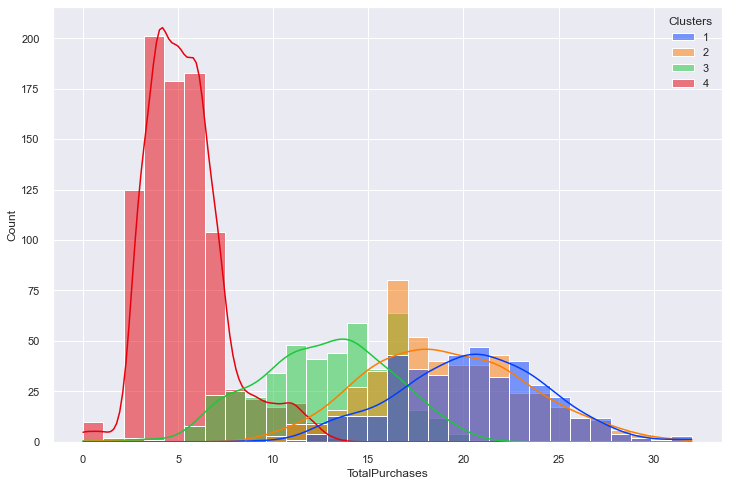

In [69]:
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x="TotalPurchases", bins=30, kde=True, hue="Clusters", palette="bright")

<AxesSubplot:xlabel='Spent', ylabel='Count'>

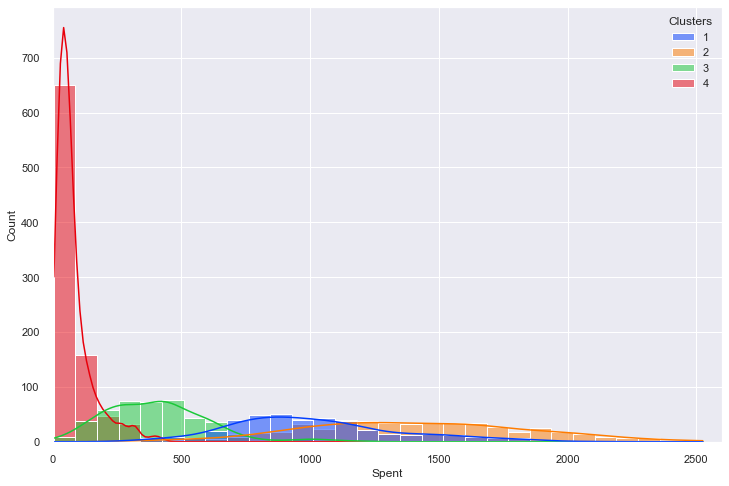

In [70]:
plt.figure(figsize=(12, 8))
plt.xlim(0, 2600)
sns.histplot(data=data, x="Spent", bins=30, kde=True, hue="Clusters", palette="bright")

* 4 Cluster is Low spending
* 3 Cluster is Medium spending
* 2 Cluster is High spending
* 1 Cluster is Medium-High spending

<Figure size 864x576 with 0 Axes>

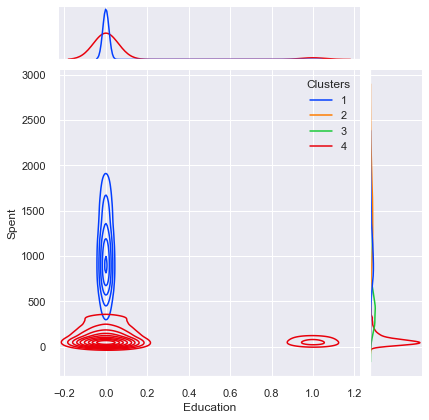

<Figure size 864x576 with 0 Axes>

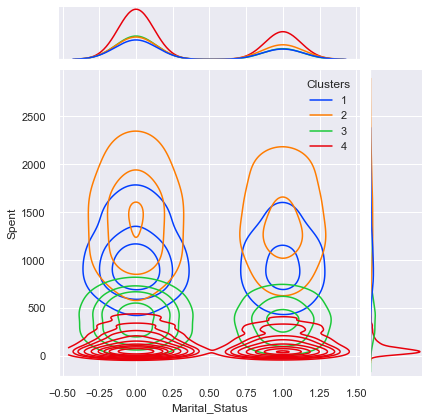

<Figure size 864x576 with 0 Axes>

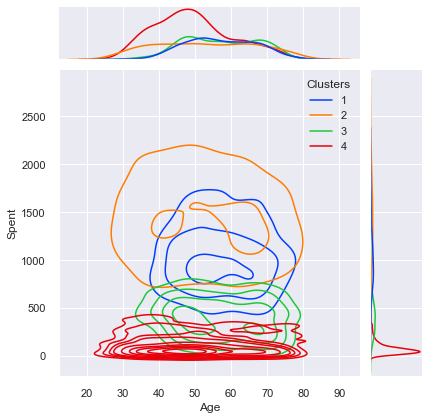

<Figure size 864x576 with 0 Axes>

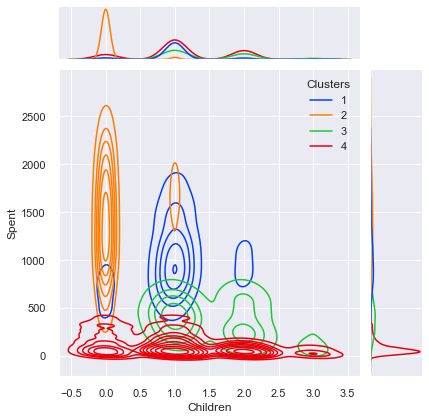

<Figure size 864x576 with 0 Axes>

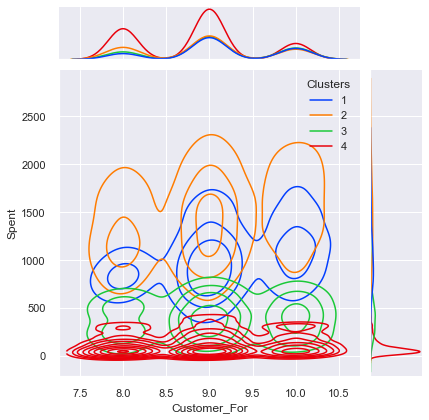

<Figure size 864x576 with 0 Axes>

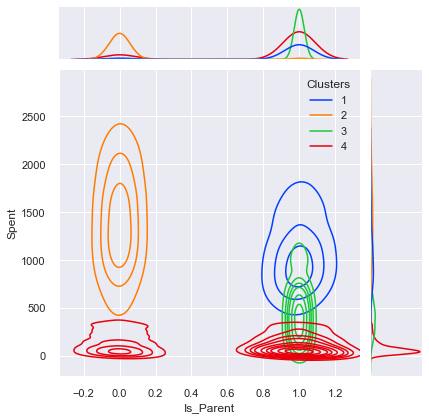

In [72]:
to_plot = ["Education", "Marital_Status", "Age", "Children", "Customer_For", "Is_Parent"]

for feature in to_plot:
    plt.figure(figsize=(12, 8))
    sns.jointplot(data=data, x=feature, y="Spent", hue="Clusters", kind="kde", palette="bright")
    plt.show()

### CLUSTERING SUMMARY

#### 1 CLUSTER
* Medium-High Income and Spendings group
* High amount of Total Purchases
* Mostly Post Graduates
* Likely to be in a relationship
* Relatively older ( 40+)
* Likely to be a parent with 1 child
* Usually customers for 9 and 10 years

#### 2 CLUSTER
* High Income and High Spendings group
* High amount of Total Purchases
* Age is spread out from young to old
* Not a parent
* No concrete tendencies in marital status

#### 3 CLUSTER
* Low-Medium Income group
* Medium amount of Total Purchases
* Medium Spendings 
* Relatively older
* More likely to be in a relationship than not
* Is a parent with 1+ children


#### 4 CLUSTER
* Predominant group
* Bigger likelihood to be Under Graduate than other groups
* Low Income, Low Spendings, Low amount of Total Purchases
* Likely to be in a relationship
* Relatively young
* Likely to be a parent with 1+ children
* Usually are customers for 8-9 years

Thanks for reading, I hope you enjoyed my work!